<a href="https://colab.research.google.com/github/suzana-ilic/chatbot/blob/master/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Scalable AI Chatbot

This notebook is based on the [MLT](https://www.meetup.com/Machine-Learning-Tokyo/events/272502001/) workshop by Bespoke R&D Lead Max Frenzel and ML Engineer Asir Saeed. You can find the [repository here](https://github.com/bespoke-inc/bespoke-public-talks/tree/master/2020/2020-08-22-MLT-Rules-to-DL) and the presentation and video tutorial on [MLT YouTube](https://www.youtube.com/mltokyo).

In [ ]:
#!wget https://raw.githubusercontent.com/bespoke-inc/bespoke-public-talks/master/2020/2020-08-22-MLT-Rules-to-DL/requirements.txt
#!pip install -r requirements.txt
#!wget https://raw.githubusercontent.com/bespoke-inc/bespoke-public-talks/master/2020/2020-08-22-MLT-Rules-to-DL/training_sample.json

In [3]:
import pandas as pd
import json

In [4]:
training_data = json.load(open('./training_sample.json','r'))

In [5]:
list(training_data.keys())

['hotel.when_is_check_in',
 'hotel.when_is_check_out',
 'hotel.is_there_early_check_in',
 'hotel.is_there_late_check_out',
 'hotel.where_is_the_front_desk_located']

In [6]:
answers = {
    'hotel.when_is_check_in': 'Check in is at 3pm!',
    'hotel.when_is_check_out': 'Check out is at 10am!',
    'hotel.is_there_late_check_out': 'For early check-out or late check-in please schedule beforehand',
    'hotel.is_there_early_check_in': 'For early check-out or late check-in please schedule beforehand',
    'hotel.where_is_the_front_desk_located': 'Front desk is located on the 2nd floor'
    }

In [7]:
import re

In [8]:
punct_re_escape = re.compile('[%s]' % re.escape('!"#$%&()*+,./:;<=>?@[\\]^_`{|}~'))

class MyChatbotData:
    
    def __init__(self, json_obj, text_fld, answers):
        dfs = []
        for i, (intent, data) in enumerate(json_obj.items()):
            # lowercase and remove punctuation
            patterns = data[text_fld].copy()
            for i, p in enumerate(patterns):
                p = p.lower()
                p = self.remove_punctuation(p)
                patterns[i] = p
                answer = answers[intent]
            df = pd.DataFrame(list(zip([intent]*len(patterns), patterns, [answer]*len(patterns))), \
                              columns=['intent', 'phrase', 'answer'])
            dfs.append(df)
        self.df = pd.concat(dfs)
    
    def get_answer(self, intent):
        return pd.unique(self.df[self.df['intent'] == intent]['answer'])[0]
    
    def remove_punctuation(self, text):
        return punct_re_escape.sub('', text)
    
    def get_phrases(self, intent):
        return list(self.df[self.df['intent'] == intent]['phrase'])
    
    def get_intents(self):
        return list(pd.unique(self.df['intent']))
    
    def show_batch(self, size=5):
        return self.df.head(size)
    
    def __len__(self):
        return len(self.df)

In [9]:
chatbot_data = MyChatbotData(training_data, 'patterns', answers)


In [10]:
len(chatbot_data)


368

### Rule-based intent classification matching

In [11]:
UNK = "Hmm I'm not sure."


In [12]:
def exact_match(query):
    intents = chatbot_data.get_intents()
    for i in intents:
        phrases = chatbot_data.get_phrases(i)
        if query in phrases:
            return chatbot_data.get_answer(i)
    return UNK

In [13]:
exact_match("is there early check-in")


'For early check-out or late check-in please schedule beforehand'

In [14]:
exact_match("can i check-in earlier than 12pm")


"Hmm I'm not sure."

#### Preprocessing
* CJK
* normalize contractions
* remove hyphens
* remove stopwords
* check for typos
* normalize plurals
* normalize ascii
* normalize emojis
* remove punctuation

In [15]:
EMOJIS = [[':)', '😀'],[';)', '😉'],[':(', '😞'],[';((', '😢'],[':p', '😛']]
_emoji_re = '[\U00010000-\U0010ffff]+'
emoji_re = re.compile(_emoji_re, flags=re.UNICODE)

def emoji_normalize(text):
    for e1, e2 in EMOJIS:
        text = text.replace(e1, e2)
    return text

def is_emoji(text):
    emoji = "".join(re.findall(_emoji_re, text))
    return emoji == text

def emoji_isolate(text):
    EMJ = "__EMOJI__"
    emoji_list = re.findall(_emoji_re, text)
    text = emoji_re.sub(f" {EMJ} ", text)
    new_str, ctr = [], 0
    for tok in text.split():
        if tok == EMJ:
            new_str.append(emoji_list[ctr])
            ctr += 1
        else:
            new_str.append(tok)
    return " ".join(new_str).strip()

In [16]:
import unicodedata

def ascii_normalize(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8")


In [17]:
punct_re_escape = re.compile('[%s]' % re.escape('!"#$%&()*+,./:;<=>?@[\\]^_`{|}~'))

def remove_punctuation(text):
    punct_re_escape.sub('', text)

In [18]:
def preprocess(text):
    text = ascii_normalize(text) or text
    text = emoji_normalize(text) or text
    text = emoji_isolate(text) or text
    text = remove_punctuation(text) or text
    return text

### Further pre-processing

Instead of checking is the entire query string exists in our dataset, we try to find a partial match and pick the intent that matches most closely. We will try to do this with using Levenshtein Distance to calculate the differences between sequences. The library fuzzywuzzy can help us do this.



In [19]:
from fuzzywuzzy import process

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [20]:
def fuzzy_matching(query):
    intents = chatbot_data.get_intents()
    for i in intents:
        phrases = chatbot_data.get_phrases(i)
        match, score = process.extractOne(query, phrases)
        if score > 90:
            return chatbot_data.get_answer(i)
    return UNK

In [21]:
fuzzy_matching("what time is early check-in")

'Check in is at 3pm!'

In [22]:
fuzzy_matching("when do i check-in")


'Check in is at 3pm!'

In [23]:
fuzzy_matching("hey I want to know what time is early check-in")

"Hmm I'm not sure."

### ML Classification
We will now add a probabilistic classifier to our set of methods to get better intent classification. The algorithm we will use is a Naive Bayes classifier that works quite well for small amount of training data.



In [24]:
import spacy

In [25]:
nlp = spacy.load('en_core_web_sm',parse=False,tagger=False)


/usr/local/lib/python3.6/dist-packages/spacy/util.py:271: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [26]:
doc = nlp("when can i check in?")
[tok.text for tok in doc]


['when', 'can', 'i', 'check', 'in', '?']

In [27]:
doc = nlp("thank you ありがとう")
[tok.text for tok in doc]


['thank', 'you', 'ありがとう']

In [28]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))


In [30]:
print(stopwords)

{'those', 'nor', 'of', 'its', 'mustn', "it's", 'our', 'what', 'in', 'be', 'herself', 'being', 'will', 'most', 'ours', "hasn't", 'hadn', 'while', 'because', 'll', 'here', 'him', 'further', 'their', 'then', 'from', "you've", 'why', 'few', 'some', 'with', 'they', 'itself', 'an', 'can', 'shan', "isn't", 'how', 'such', 'but', 'd', 'shouldn', 'very', 'during', 'now', 'myself', 'on', "you'll", 'won', 'don', 'not', 'has', 'at', "should've", 'yours', 'o', 'didn', 'aren', "wasn't", 'no', 'and', 'am', "couldn't", 'these', 'themselves', "you're", "mightn't", 'whom', "needn't", 'hasn', 'that', 'your', 'doing', 'you', 'which', 'are', 'y', 'me', 'if', 'been', 'once', "doesn't", 'had', 'below', "you'd", 'up', "wouldn't", 'was', 'did', 'under', 'when', 'i', "she's", 'hers', 'her', 'both', 've', 'ain', 'where', 'own', 'so', 'his', 'there', 'couldn', "haven't", 'through', 'theirs', "shan't", 'over', 'more', "that'll", 'haven', 'this', 'by', 'were', 'above', 'other', 'for', 'yourselves', 'ma', 'wouldn', '

In [31]:
def tokenize_nd_join(text):
    doc = nlp(text.lower())
    return " ".join(tok.text for tok in doc if tok.text.strip() not in stopwords)


In [32]:
def get_xs_ys(train_data):
    x, y = [], []
    intents = chatbot_data.get_intents()
    for i in intents:
        phrases = chatbot_data.get_phrases(i)
        x += [tokenize_nd_join(phrase) for phrase in phrases]
        y += [i]*len(phrases)
    return x, y


In [33]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [34]:
def train(x,y):
    vect = CountVectorizer(ngram_range=(1,2),max_features=None)
    nb = Pipeline([('vect',vect),('clf',ComplementNB(alpha=1.0,norm=False))])
    nb.fit(x,y)
    return nb


In [35]:
x, y = get_xs_ys(training_data)
nb_model = train(x, y)


In [36]:
def nb_pred(query):
    tokenized_query = tokenize_nd_join(query)
    pred = nb_model.predict([tokenized_query])[0]
    return chatbot_data.get_answer(pred)


In [37]:
nb_pred("what time is early check-in")


'For early check-out or late check-in please schedule beforehand'

In [38]:
nb_pred("hey I want to know what time is early check-in")

'For early check-out or late check-in please schedule beforehand'

In [39]:
nb_pred("early check-in time")

'For early check-out or late check-in please schedule beforehand'

In [40]:
import numpy as np


In [41]:
def nb_pred_top3(query):
    tokenized_query = tokenize_nd_join(query)
    pred_prob = nb_model.predict_proba([tokenized_query])
    preds_sorted = np.argsort(pred_prob)
    top3 = preds_sorted[:,-1],preds_sorted[:,-2],preds_sorted[:,-2]
    if pred_prob[0,top3[0]] > (pred_prob[0,top3[1]] + pred_prob[0,top3[2]]):
        pred = nb_model.named_steps['clf'].classes_[top3[0]][0]
        return chatbot_data.get_answer(pred)
    return UNK

In [42]:
nb_pred_top3("hey I want to know about early check-in time")

'For early check-out or late check-in please schedule beforehand'

### Intent Classification Pipeline¶


In [43]:
def get_pred(query):
    query = query.lower()
    pred = exact_match(query)
    if pred == UNK: pred = exact_match(preprocess(query))
    if pred == UNK: pred = nb_pred_top3(query)
    if pred == UNK: pred = nb_pred_top3(preprocess(query))
    if pred == UNK: pred = fuzzy_matching(query)
    if pred == UNK: pred = fuzzy_matching(preprocess(query))
    return pred


In [44]:
get_pred("when is check-in")

'Check in is at 3pm!'

In [45]:
get_pred("where can i find the front desk?")


'Front desk is located on the 2nd floor'

#### Moving ML to DL
We see that this pipeline using some rules and a probabilistic model are working quite well. However, it doesn't scale with data and requires adding a lot of preprocessing and nuances to get working properly

- Pros:

There are noticeable improvements in using NNs over the current probabilistic model. Model can scale with data i.e it can improve as we add more annotated training data
This can be a good point to move to NNs, since we are reaching the limits of rule based systems e.g fewer engineered features 

- Cons:

Huge gains cannot be seen until the data is cleaned. In its current state, the model will either be the same or slightly better than the current approach.

### Classification with DistilBert

In [46]:
from fastai import *
from fastai.text import *


In [47]:
answers = {
    'hotel.when_is_check_in': 'Check in is at 3pm!',
    'hotel.when_is_check_out': 'Check out is at 10am!',
    'hotel.is_there_late_check_out': 'For early check-out or late check-in please schedule beforehand',
    'hotel.is_there_early_check_in': 'For early check-out or late check-in please schedule beforehand',
    'hotel.where_is_the_front_desk_located': 'Front desk is located on the 2nd floor'
    }


In [48]:
class MyChatbotData:
    
    def __init__(self, json_obj, text_fld, answers):
        dfs = []
        for i, (intent, data) in enumerate(json_obj.items()):
            # lowercase and remove punctuation
            patterns = data[text_fld].copy()
            for i, p in enumerate(patterns):
                p = p.lower()
                p = self.remove_punctuation(p)
                patterns[i] = p
                answer = answers[intent]
            df = pd.DataFrame(list(zip([intent]*len(patterns), patterns, [answer]*len(patterns))), \
                              columns=['intent', 'phrase', 'answer'])
            dfs.append(df)
        self.df = pd.concat(dfs)
    
    def get_answer(self, intent):
        return pd.unique(self.df[self.df['intent'] == intent]['answer'])[0]
    
    def remove_punctuation(self, text):
        return punct_re_escape.sub('', text)
    
    def get_phrases(self, intent):
        return list(self.df[self.df['intent'] == intent]['phrase'])
    
    def get_intents(self):
        return list(pd.unique(self.df['intent']))
    
    def show_batch(self, size=5):
        return self.df.head(size)
    
    def __len__(self):
        return len(self.df)

In [49]:
training_data = json.load(open('./training_sample.json','r'))


In [50]:
list(training_data.keys())


['hotel.when_is_check_in',
 'hotel.when_is_check_out',
 'hotel.is_there_early_check_in',
 'hotel.is_there_late_check_out',
 'hotel.where_is_the_front_desk_located']

In [51]:
chatbot_data = MyChatbotData(training_data, 'patterns', answers)

In [52]:
df = chatbot_data.df
df.head()

,intent,phrase,answer
0,hotel.when_is_check_in,when is check-in,Check in is at 3pm!
1,hotel.when_is_check_in,how to check in,Check in is at 3pm!
2,hotel.when_is_check_in,what time is the latest we can check into the ...,Check in is at 3pm!
3,hotel.when_is_check_in,what time is check in open till,Check in is at 3pm!
4,hotel.when_is_check_in,can you advise the check in time,Check in is at 3pm!


In [53]:
len(set(df['intent'])), len(df)


(5, 368)

In [54]:
path = Path('./')


In [55]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import PreTrainedTokenizer


In [56]:
class TransformersBaseTokenizer(BaseTokenizer):
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        tokens = [CLS] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [SEP]
        return tokens

In [57]:
transformer_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])


In [58]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})


In [59]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]


In [60]:
pad_idx = transformer_tokenizer.pad_token_id

databunch = (TextList.from_df(df, cols='phrase', processor=transformer_processor)
             .split_by_rand_pct()
             .label_from_df(cols= 'intent')
             .databunch(bs=64, pad_first=False, pad_idx=pad_idx))

In [61]:
class TransformerModel(nn.Module):
  
    def __init__(self, transformer):
        super(TransformerModel,self).__init__()
        self.transformer = transformer
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits

In [62]:
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
config.num_labels = databunch.train_ds.c

distil_bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)
transformer_model = TransformerModel(distil_bert)


In [63]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learn = Learner(databunch, transformer_model, opt_func = CustomAdamW, metrics=[accuracy])

In [64]:
list_layers = [learn.model.transformer.base_model.embeddings,
               learn.model.transformer.base_model.transformer.layer[0],
               learn.model.transformer.base_model.transformer.layer[1],
               learn.model.transformer.base_model.transformer.layer[2],
               learn.model.transformer.base_model.transformer.layer[3],
               learn.model.transformer.base_model.transformer.layer[4],
               learn.model.transformer.base_model.transformer.layer[5],
               learn.model.transformer.pre_classifier,
               learn.model.transformer.classifier]
               
learn.split(list_layers);

In [65]:
learn.freeze_to(-2)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


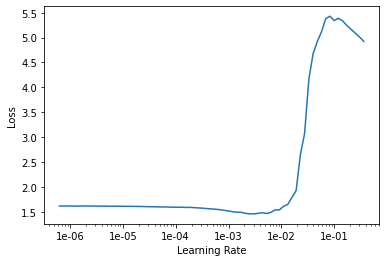

In [66]:
learn.lr_find()
learn.recorder.plot(skip_end=15)


In [67]:
learn.fit_one_cycle(3,max_lr=1e-3,moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.820978,1.801066,0.178082,00:06
1,1.727357,1.424789,0.410959,00:06
2,1.617617,1.390422,0.534247,00:06


In [68]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(8e-4/(2.6**4),8e-4), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,2.665271,1.807662,0.561644,00:07
1,2.063024,0.875780,0.698630,00:08


In [69]:
learn.freeze_to(-5)
learn.fit_one_cycle(2, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.013246,1.667955,0.178082,00:11
1,2.792480,1.525039,0.342466,00:12


In [70]:
learn.freeze_to(-8)
learn.fit_one_cycle(2, slice(3e-4/(2.6**4),3e-4), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.634950,2.581532,0.356164,00:16
1,1.637631,1.427630,0.479452,00:17


In [71]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.364060,1.265836,0.493151,00:18
1,1.285199,1.000256,0.602740,00:19
2,1.196618,0.860942,0.657534,00:19
3,1.096579,0.745196,0.657534,00:19
4,1.025829,0.713188,0.657534,00:18


In [72]:
learn.predict("what flights are available from pittsburgh to baltimore")


/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


(Category tensor(0),
 tensor(0),
 tensor([0.3998, 0.1760, 0.2234, 0.1136, 0.0872]))

In [73]:
interp = TextClassificationInterpretation(learn,*learn.get_preds(with_loss=True))


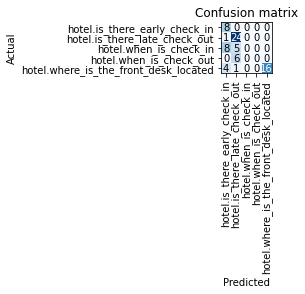

In [74]:
interp.plot_confusion_matrix()

In [75]:
interp.show_top_losses(20)


Text,Prediction,Actual,Loss,Probability
[CLS] can i check ##in early [SEP],hotel.is_there_late_check_out,hotel.is_there_early_check_in,3.12,0.17
[CLS] can i delay my check ##out [SEP],hotel.is_there_early_check_in,hotel.is_there_late_check_out,2.50,0.20
[CLS] late check out [SEP],hotel.is_there_early_check_in,hotel.is_there_late_check_out,2.35,0.17
[CLS] i want to check in [SEP],hotel.is_there_early_check_in,hotel.where_is_the_front_desk_located,1.92,0.15
[CLS] how do i reach front office [SEP],hotel.is_there_late_check_out,hotel.where_is_the_front_desk_located,1.56,0.04
[CLS] i would like to know the check in time [SEP],hotel.is_there_early_check_in,hotel.when_is_check_in,1.46,0.23
[CLS] where is the office [SEP],hotel.is_there_early_check_in,hotel.where_is_the_front_desk_located,1.46,0.08
[CLS] where is the front desk [SEP],hotel.is_there_early_check_in,hotel.where_is_the_front_desk_located,1.45,0.07
[CLS] i need to go to the front desk [SEP],hotel.is_there_late_check_out,hotel.where_is_the_front_desk_located,1.44,0.05
[CLS] can you advise the check in time [SEP],hotel.is_there_late_check_out,hotel.when_is_check_in,1.43,0.24
